# Analyses of trial clusters

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap

# Get my functions
functions_path = prefix + 'representation_learning_variability/Models/Sub-trial//4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
from clustering_functions import revert_to_original, get_ballistic, get_no_resp
functions_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import transition_probabilities, rescale_sequence
from plotting_functions import plot_binned_sequence
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Get data

In [3]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [4]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_no_timing03-19-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

In [ ]:
# use_key = 'feedback' # session trial_typefilter
# use_order = ['correct', 'incorrect']
# # use_order = ['0.0', '0.0625', '0.125', '0.25', '1.0']
# # use_order = ['0.5', '0.2', '0.8']
# unique_numeric_labels = np.arange(0, len(use_order), 1)
# map_to_use = dict(zip(use_order, unique_numeric_labels))

# # Apply map
# unique_trial_types = trial_clusters[use_key].unique()
# # trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
# trial_clusters['numeric_trial_code'] = trial_clusters[use_key].map(map_to_use)

In [5]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'cluster_per_trial_part_info03-21-2025')
trial_clusters = pd.read_parquet(filename, engine='pyarrow')

trial_clusters['session'] = trial_clusters['old_sample'].str.split().str[:1].str.join('')
trial_clusters['trial_id'] = trial_clusters['old_sample'].str.split().str[1:2].str.join('')

In [6]:
# Load trial clsuters
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/'
parts_filename = str(results_path + 'cluster_per_session_part03-21-2025')
parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

parts_clusters['part_cluster'] = [1 if x == 0 else 0 if x == 1 else x for x in parts_clusters['part_cluster']]
# parts_clusters['session'] = parts_clusters['sample'].str.split().str[:1].str.join('')

trial_clusters = trial_clusters.merge(parts_clusters[['part_cluster', 'sample']].drop_duplicates(), on=['sample'], how='left')

## Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Trial mode')

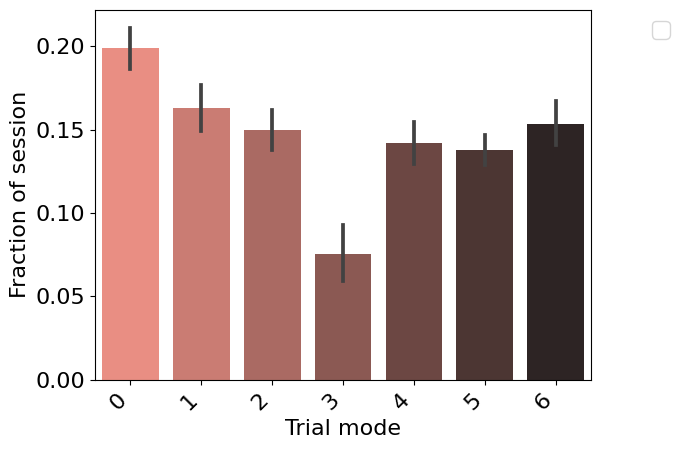

In [9]:
fractions = trial_clusters.groupby(['session', 'part_cluster'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index()

plt.rc('font', size=16)
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
sns.barplot(y='fraction', x='cluster', data=fractions, palette=palette) #hue='part_cluster', 
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Fraction of session')
plt.xlabel('Trial mode')

## Trial modes across session

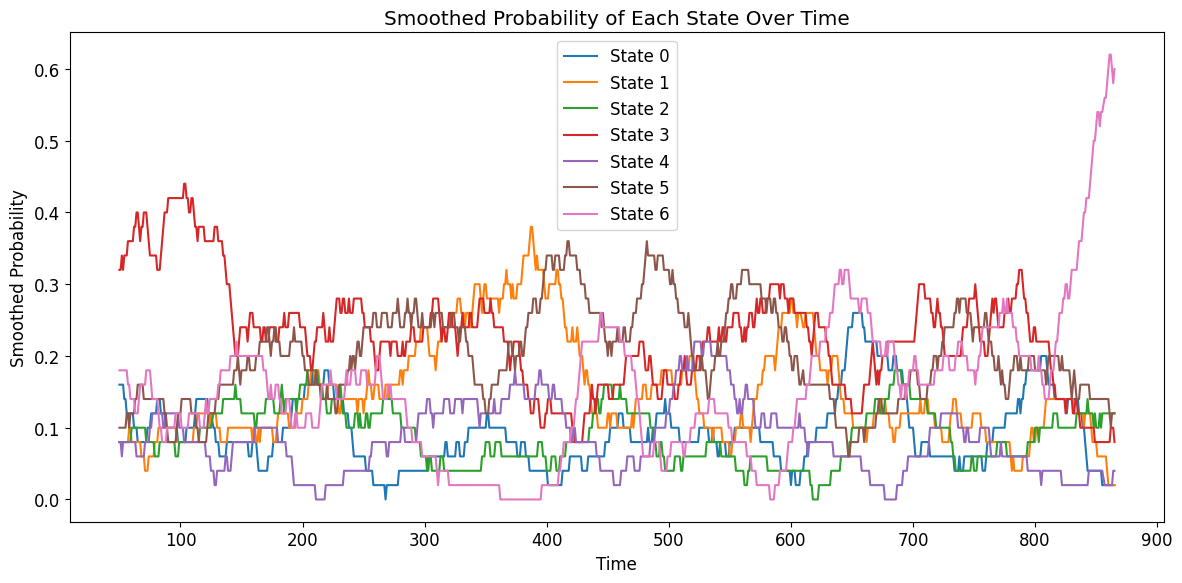

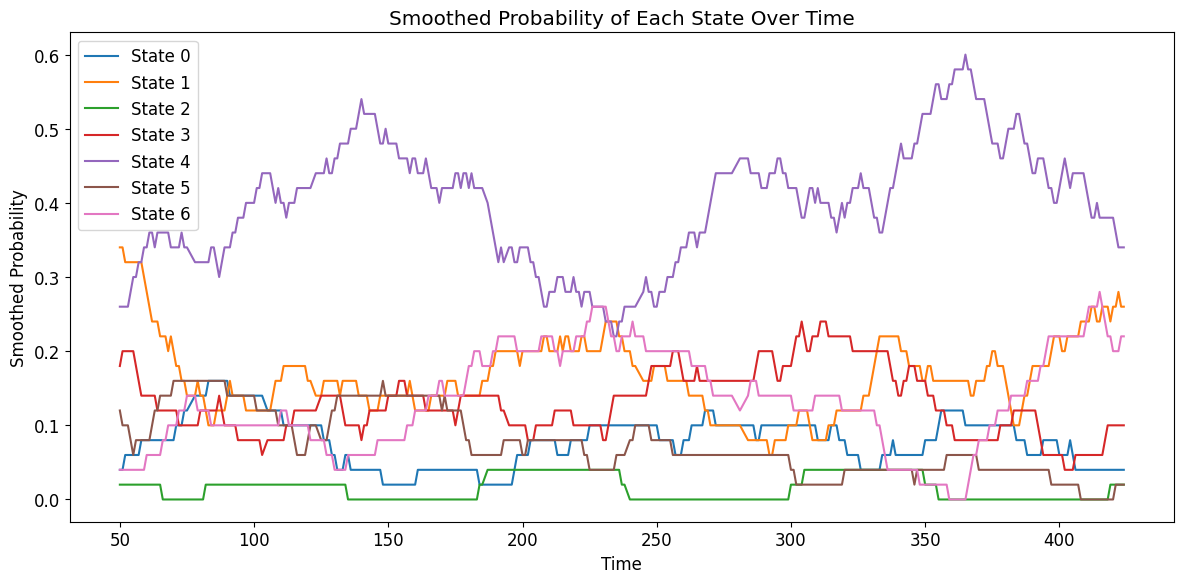

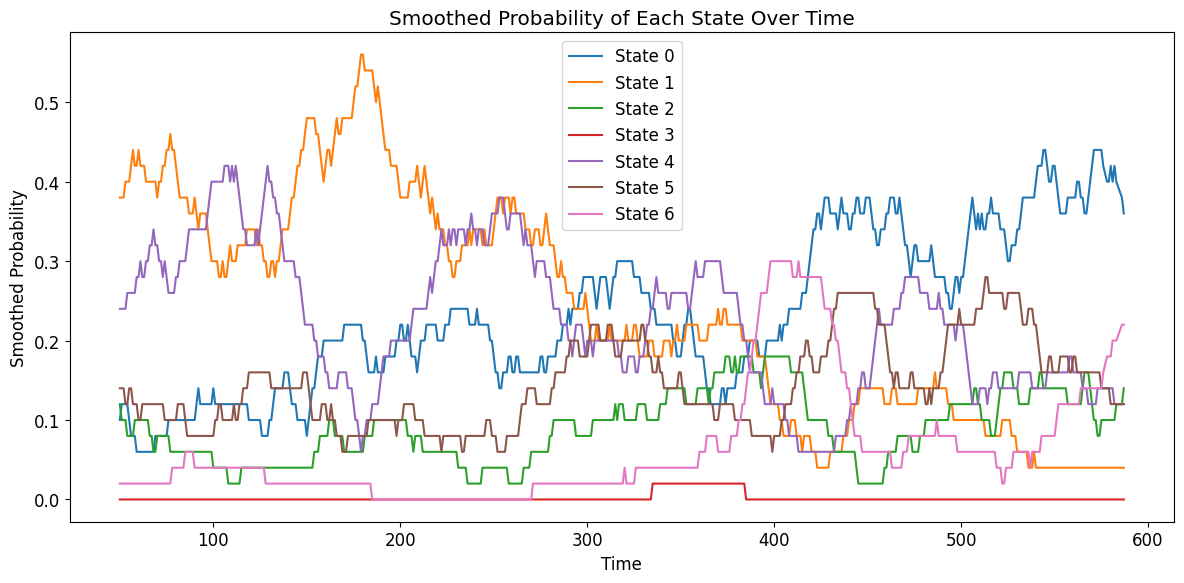

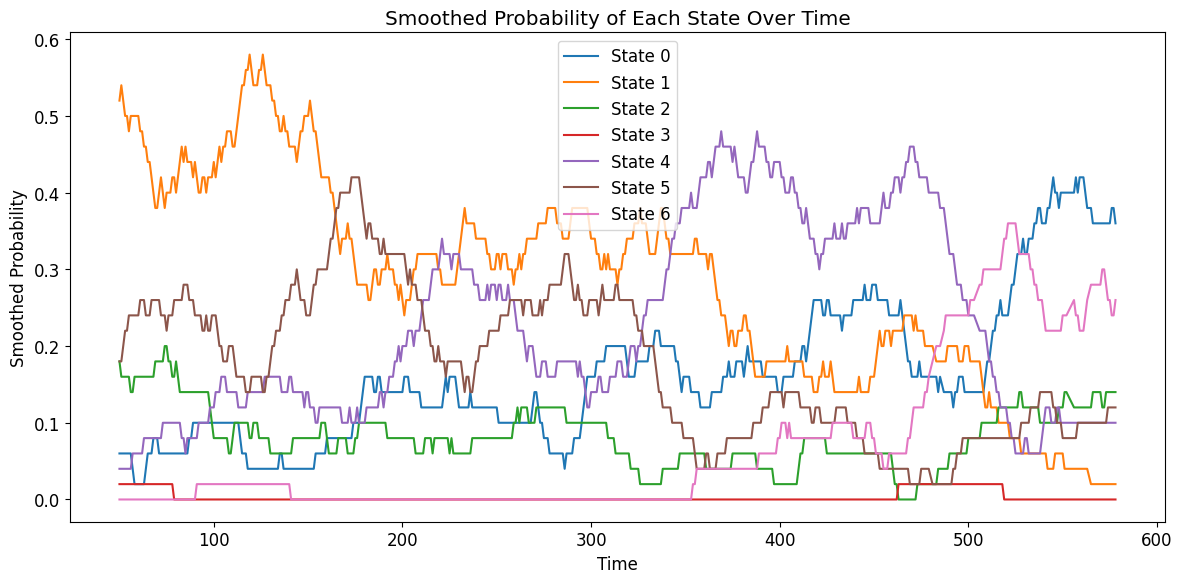

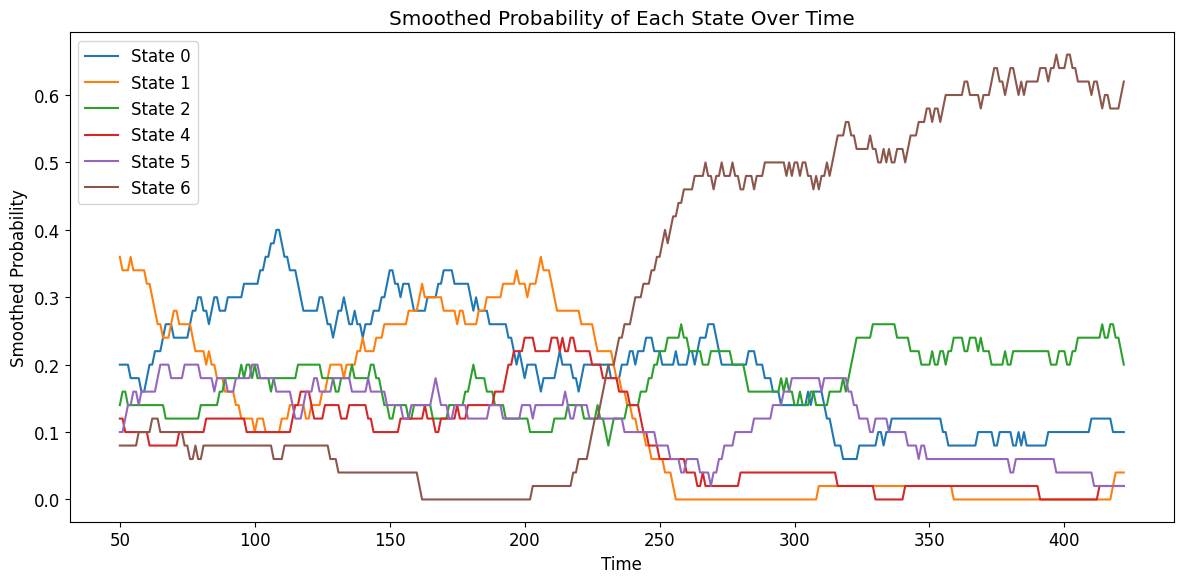

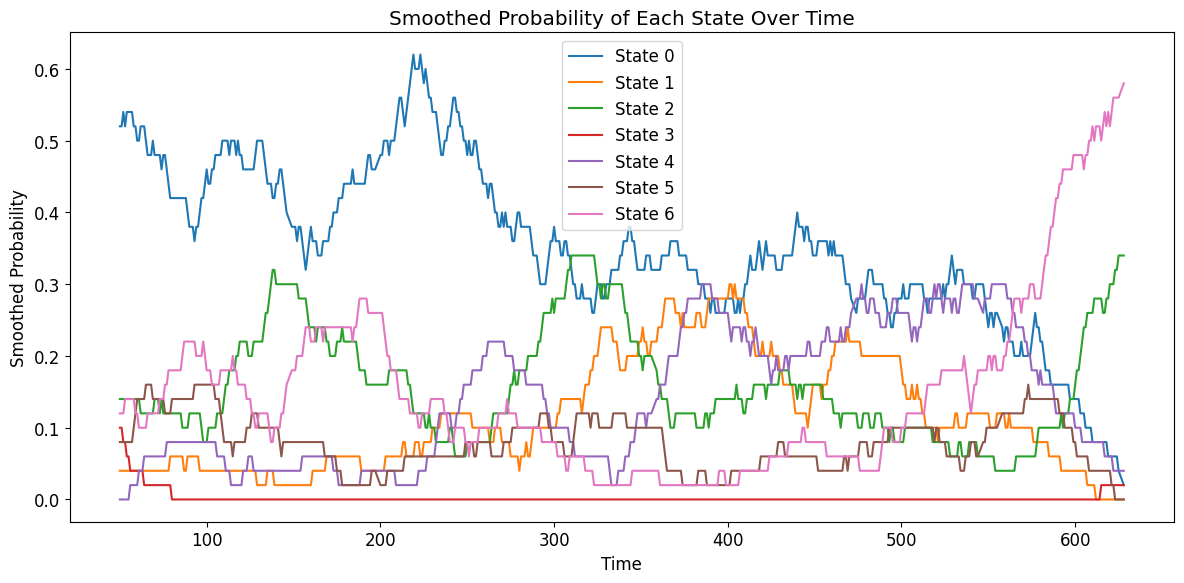

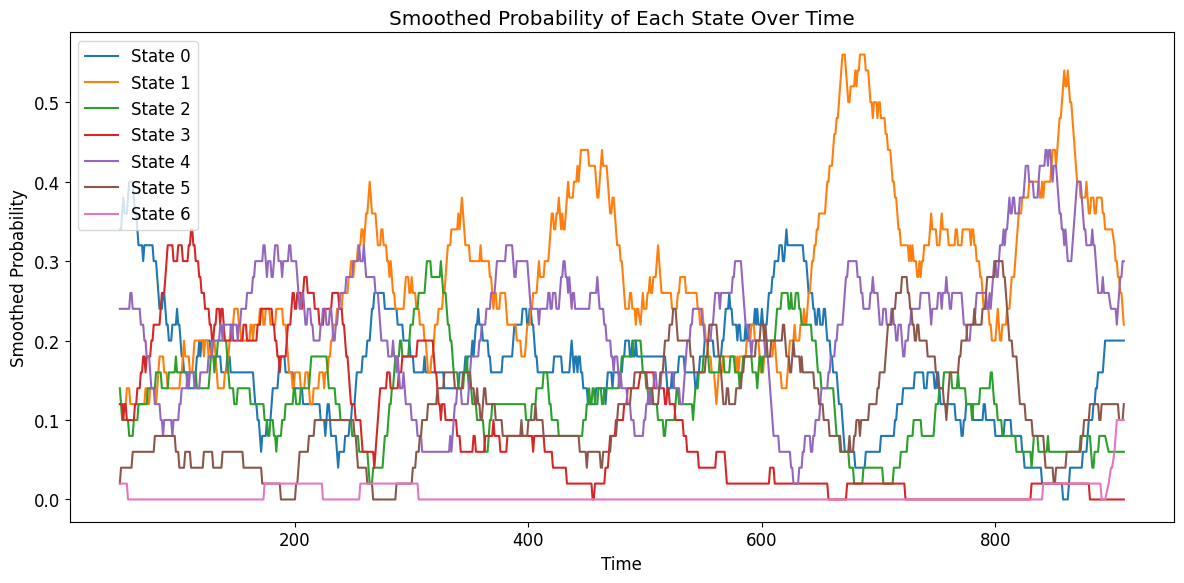

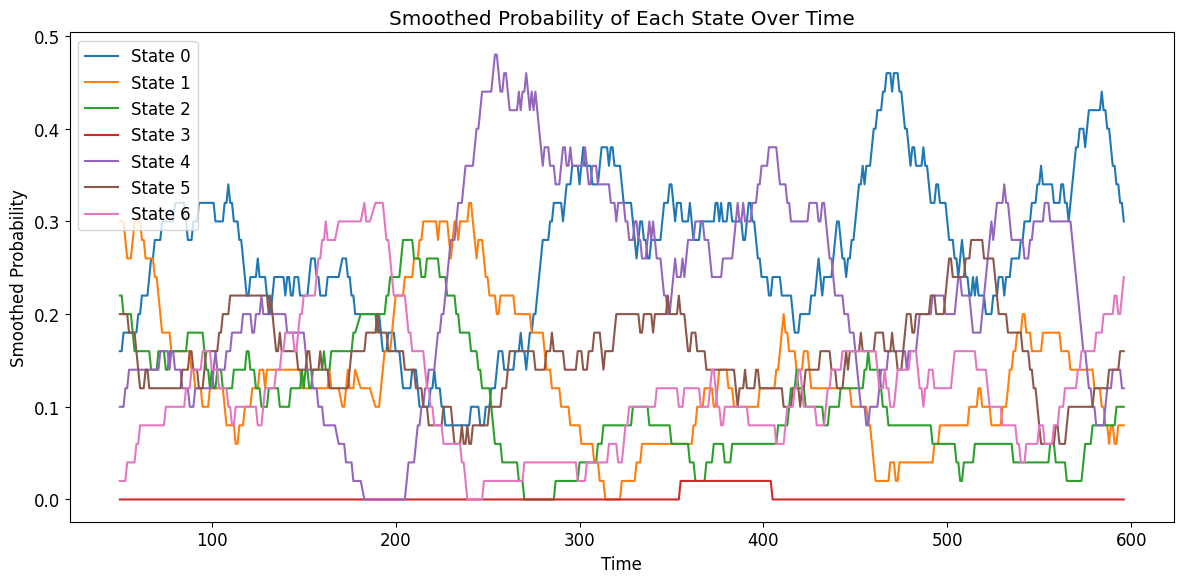

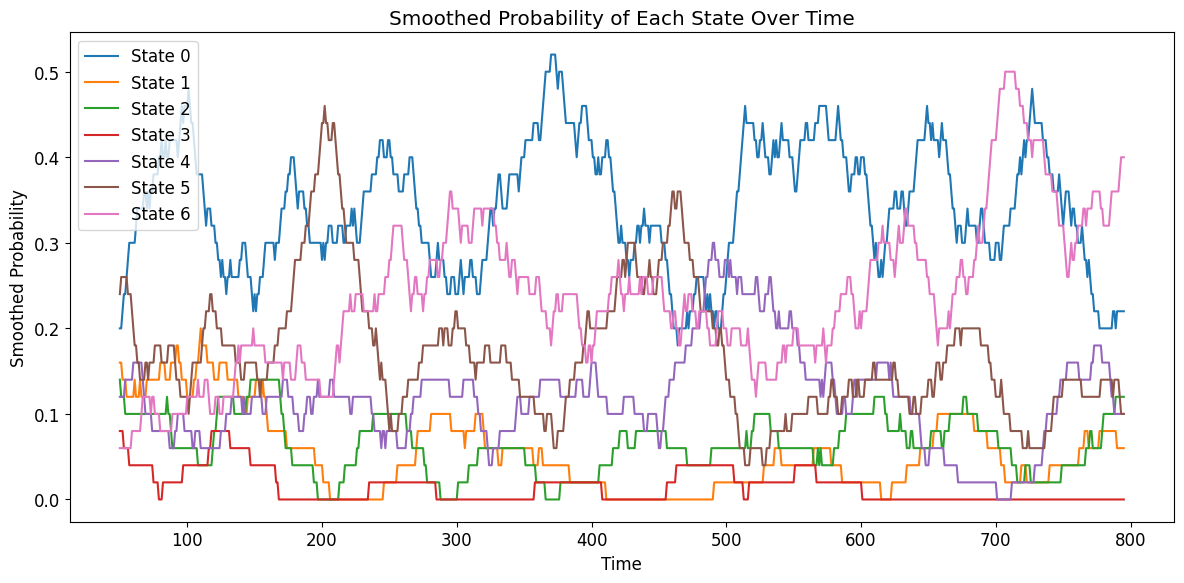

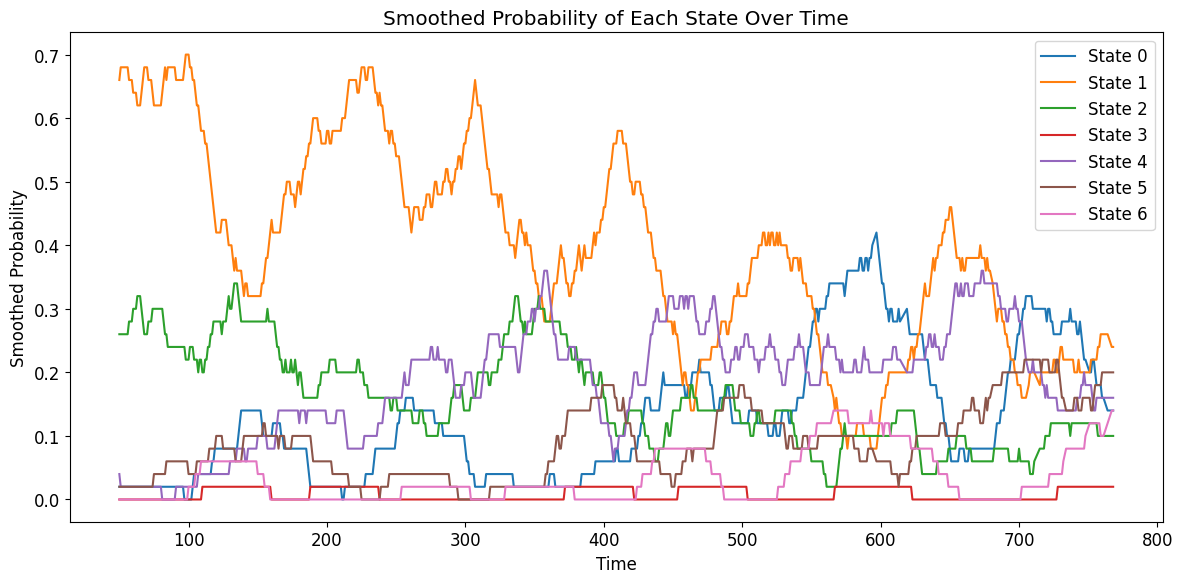

In [23]:
sessions = trial_clusters['session'].unique()

for s, session in enumerate(sessions[:10]):
    session_data = trial_clusters.loc[trial_clusters['session']==session]
    session_data = session_data[['session', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
    session_data['trial_id'] = session_data['trial_id'].astype(float)
    session_data = session_data.sort_values(by=['trial_id'])

    # One-hot encode
    df_onehot = pd.get_dummies(session_data['cluster'])

    # Optional: Rename columns to match category labels if needed
    df_onehot.columns = [f"State {i}" for i in df_onehot.columns]

    # Apply smoothing (e.g., Gaussian)
    # smoothed = df_onehot.apply(lambda x: gaussian_filter1d(x, sigma=.5), axis=0)
    smoothed = df_onehot.apply(lambda x: x.rolling(window=50, center=False).mean(), axis=0)

    # Plot
    plt.figure(figsize=(12, 6))
    for col in smoothed.columns:
        plt.plot(session_data['trial_id'], smoothed[col], label=col)
        
    plt.xlabel("Time")
    plt.ylabel("Smoothed Probability")
    plt.title("Smoothed Probability of Each State Over Time")
    plt.legend()
    # plt.xlim([0, 1000])
    plt.tight_layout()
    plt.show()

    # sns.scatterplot(x='trial_id', y='cluster', data=session_data)
    # plt.xlim([0,100])
    # plt.show()


## Empirical transition matrix per trial modes

### Warning! Part cluster does not match a single session!! Analyzes per session cannot include part clusters

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_93483/2075774756.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cluster_trans_mat['session'][s] = session
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_93483/20757

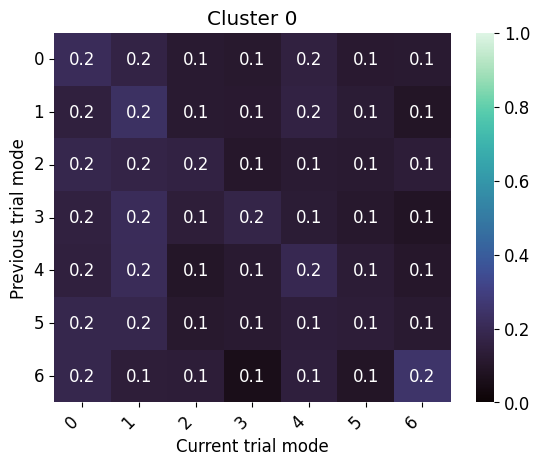

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_93483/2075774756.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cluster_trans_mat['session'][s] = session
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_93483/20757

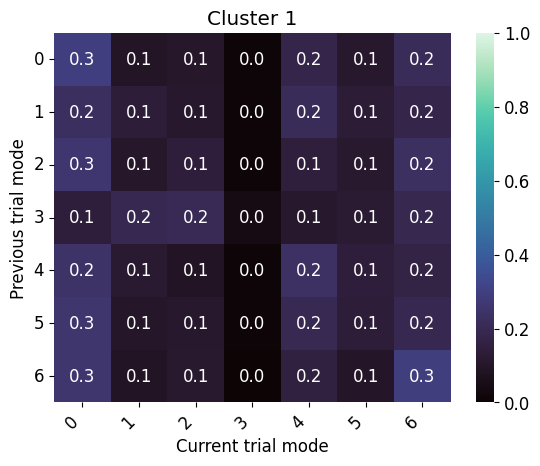

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_93483/2075774756.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cluster_trans_mat['session'][s] = session
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_93483/20757

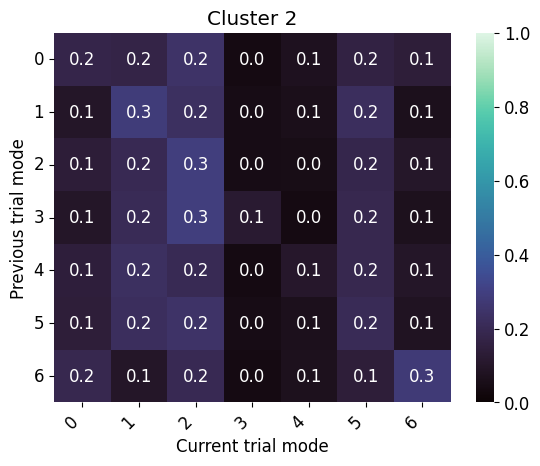

In [114]:
group_trans_mat = pd.DataFrame(columns=['session', 'trans_mat', 'part_cluster'])

for c, cluster in enumerate([0, 1, 2]):
    cluster_sessions = trial_clusters.loc[trial_clusters['part_cluster']==cluster]
    cluster_trans_mat = pd.DataFrame(columns=['session', 'trans_mat', 'part_cluster'], index=range(len(cluster_sessions)))

    for s, session in enumerate(cluster_sessions['session'].unique()):

        session_data = cluster_sessions.loc[cluster_sessions['session']==session]
        session_data = session_data[['session', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
        session_data['trial_id'] = session_data['trial_id'].astype(float)
        session_data = session_data.sort_values(by=['trial_id'])

        modes = np.array(session_data['cluster'])
        unique_modes = np.arange(0, 7)
                            
        """ State transition matrix (empirical) """
        transition_matrix = transition_probabilities(modes, unique_modes)
        # plt.imshow(transition_matrix)
        # plt.xlabel('Current trial mode')
        # plt.ylabel('Previous trial mode')
        # plt.xticks(np.arange(0, 7), unique_modes)
        # plt.yticks(np.arange(0, 7), unique_modes)
        # # plt.xticks(rotation=45, ha='right')
        # plt.title('Cluster '+str(cluster))
        # plt.show()
        cluster_trans_mat['session'][s] = session
        cluster_trans_mat['trans_mat'][s] = transition_matrix
        cluster_trans_mat['part_cluster'][s] = cluster

    # Results on original model
    plt.rc('font', size=12) 
    # plt.figure(figsize=[9, 8])
    hmap = sns.color_palette("mako", as_cmap=True)
    stacked_matrices = np.stack(cluster_trans_mat['trans_mat'].dropna().values)
    nanmean_matrix = np.nanmean(stacked_matrices, axis=0)
    sns.heatmap(nanmean_matrix, annot=True, fmt='.1f',
        cmap= hmap, vmin=0, vmax=1) 
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    plt.xlabel('Current trial mode')
    plt.ylabel('Previous trial mode')
    plt.title('Cluster '+str(cluster))
    plt.show()

    group_trans_mat = pd.concat([group_trans_mat, cluster_trans_mat])


Text(46.722222222222214, 0.5, 'Previous trial mode')

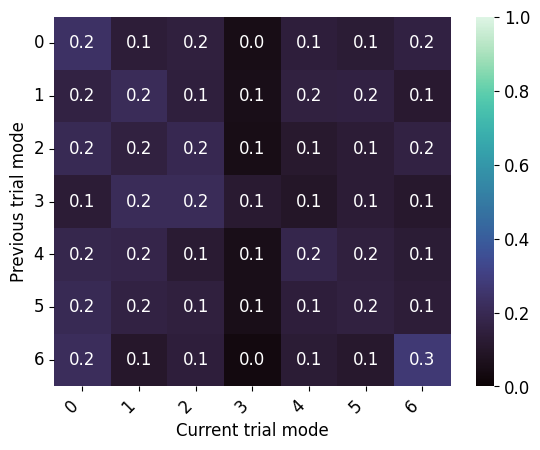

In [77]:
# Results on original model
plt.rc('font', size=12) 
# plt.figure(figsize=[9, 8])
hmap = sns.color_palette("mako", as_cmap=True)
stacked_matrices = np.stack(group_trans_mat['trans_mat'].dropna().values)
nanmean_matrix = np.nanmean(stacked_matrices, axis=0)
sns.heatmap(nanmean_matrix, annot=True, fmt='.1f',
    cmap= hmap, vmin=0, vmax=1) 
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('Current trial mode')
plt.ylabel('Previous trial mode')

## Normalize trial mode use along session

In [7]:
plot = False
target_length = 5

all_sequences = pd.DataFrame(columns=['session', 'part_cluster', 'sample', 'cluster', 'bin'])
for s, session_part in enumerate(trial_clusters['sample'].unique()):

    # Get session data and order trials
    session_data = trial_clusters.loc[trial_clusters['sample']==session_part]
    session_data = session_data[['session', 'trial_id', 'trial_type', 'sample', 'part_cluster', 'cluster']].drop_duplicates()
    session_data['trial_id'] = session_data['trial_id'].astype(float)
    session_data = session_data.sort_values(by=['trial_id'])

    # Bin 
    n_trials = len(session_data)
    # Assign bin index: split into 10 parts
    bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
    session_data['bin'] = bin_indices
    
    # if plot == True:
    #     states_to_append = np.arange(0, num_states)
    #     for i in range(100):
    #         if df_grouped['broader_label'][i] == 'Choice':
    #             plot_binned_sequence(df_grouped, i, states_to_append)    
    all_sequences = pd.concat([all_sequences, session_data[['session', 'part_cluster', 'sample',
                                                            'cluster', 'bin']]], ignore_index=True)


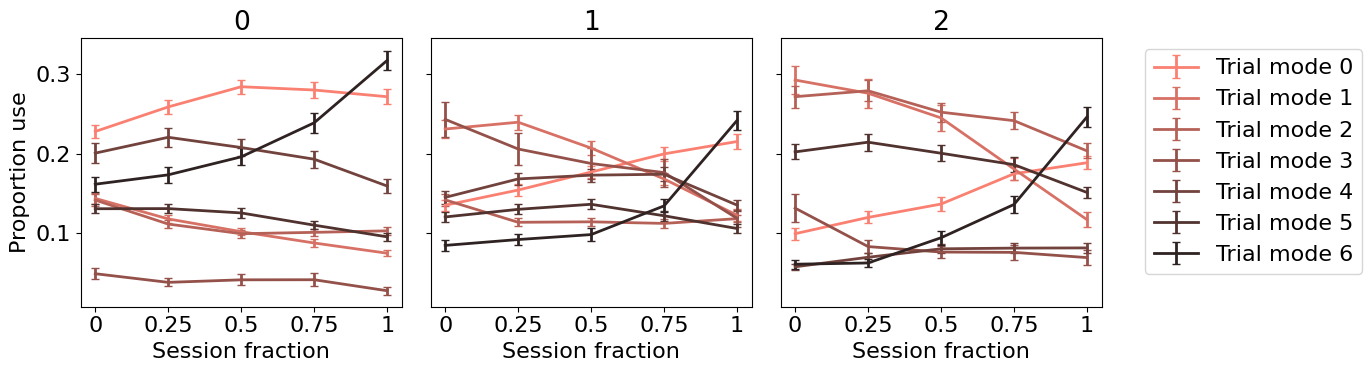

In [9]:
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())


fractions = all_sequences.groupby(['sample', 'part_cluster', 
                                   'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index()
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14, 4))

for phenotype in [0, 1, 2]:

    # Group by bin and cluster, and compute mean and SEM
    summary = fractions.loc[fractions['part_cluster']==phenotype].groupby(['bin', 
                                                                           'cluster'])['fraction'].agg(['mean', 'sem']).reset_index()
    # Ensure correct types
    summary['bin'] = summary['bin'].astype(float)
    summary['cluster'] = summary['cluster'].astype(float)

    # Prepare plot
    plt.rc('font', size=16)

    clusters = sorted(summary['cluster'].unique())

    # Plot one line with error bars for each cluster
    for i, cluster in enumerate(clusters):
        cluster_data = summary[summary['cluster'] == cluster]
        axs[phenotype].errorbar(
            cluster_data['bin'], 
            cluster_data['mean'], 
            yerr=cluster_data['sem'], 
            label=f'Trial mode {int(cluster)}',
            color=my_cmap(i),
            capsize=3,
            linewidth=2
        )

    # Customize axes
    axs[phenotype].set_xticks([0, 1, 2, 3, 4], [0, .25, .5, .75, 1])
    # axs[phenotype].set_xticks(sorted(fractions['bin'].unique()))
    # axs[phenotype].set_xticklabels([str(int(b)) for b in sorted(fractions['bin'].unique())])
    axs[phenotype].set_xlabel('Session fraction')
    axs[phenotype].set_title(str(phenotype))
axs[0].set_ylabel('Proportion use')
axs[2].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()


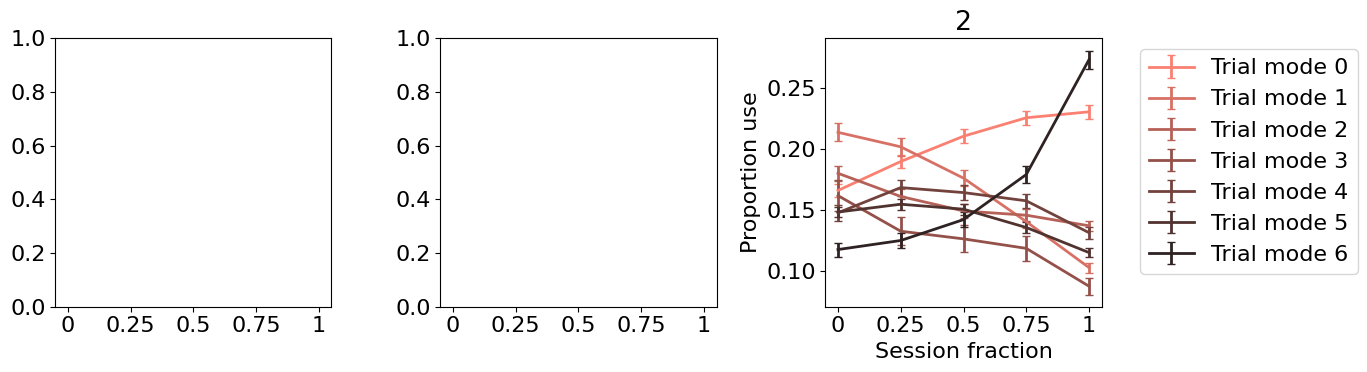

In [22]:
palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())


fractions = all_sequences.groupby(['sample', 'part_cluster', 
                                   'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index()
fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(14, 4))


# Group by bin and cluster, and compute mean and SEM
summary = fractions.groupby(['bin', 'cluster'])['fraction'].agg(['mean', 'sem']).reset_index()
# Ensure correct types
summary['bin'] = summary['bin'].astype(float)
summary['cluster'] = summary['cluster'].astype(float)

# Prepare plot
plt.rc('font', size=16)
clusters = sorted(summary['cluster'].unique())

# Plot one line with error bars for each cluster
for i, cluster in enumerate(clusters):
    cluster_data = summary[summary['cluster'] == cluster]
    axs[phenotype].errorbar(
        cluster_data['bin'], 
        cluster_data['mean'], 
        yerr=cluster_data['sem'], 
        label=f'Trial mode {int(cluster)}',
        color=my_cmap(i),
        capsize=3,
        linewidth=2
    )

# Customize axes
axs[phenotype].set_xticks([0, 1, 2, 3, 4], [0, .25, .5, .75, 1])
# axs[phenotype].set_xticks(sorted(fractions['bin'].unique()))
# axs[phenotype].set_xticklabels([str(int(b)) for b in sorted(fractions['bin'].unique())])
axs[phenotype].set_xlabel('Session fraction')
axs[phenotype].set_title(str(phenotype))
axs[2].set_ylabel('Proportion use')
axs[2].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()


## Plot ballistic stats per cluster

In [23]:
use_data = trial_clusters.copy()
use_data = get_no_resp(use_data)
use_data.loc[use_data['resp']=='response', 'resp'] = 1
use_data.loc[use_data['resp']=='non_response', 'resp'] = 0
use_data = pd.DataFrame(use_data.groupby(['broader_label', 'cluster', 'mouse_name'])['resp'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='cluster', y='resp', hue='broader_label', alpha=0.8,
            data=use_data, hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']) # hue_order=['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI']
plt.xlabel('Cluster')
plt.ylabel('Proportion of response-plausible movements')
plt.show()

KeyError: 'identifiable_states'

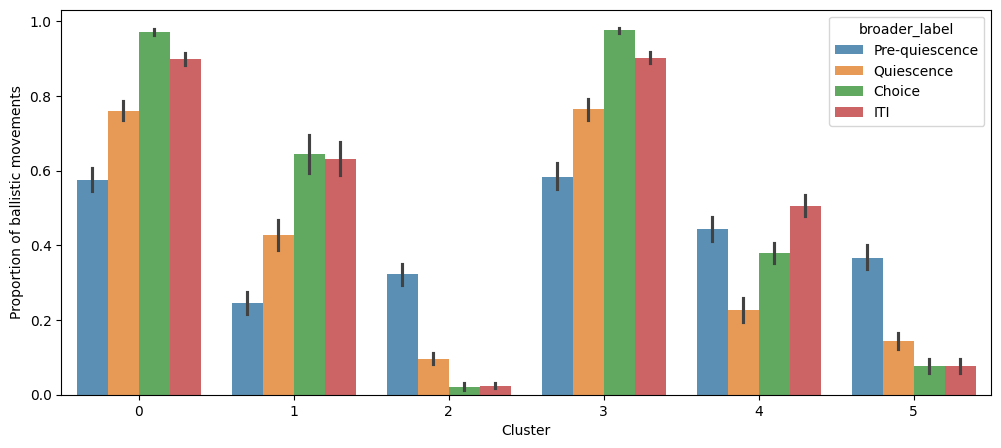

In [25]:
use_data = trial_clusters.copy()
use_data = get_ballistic(use_data)
use_data.loc[use_data['bal_state']=='balistic', 'bal_state'] = 1
use_data.loc[use_data['bal_state']=='non_balistic', 'bal_state'] = 0
use_data = pd.DataFrame(use_data.groupby(['broader_label', 'cluster', 'mouse_name'])['bal_state'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='cluster', y='bal_state', hue='broader_label', alpha=0.8,
            data=use_data, hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'])
plt.xlabel('Cluster')
plt.ylabel('Proportion of ballistic movements')
plt.show()